In [1]:
import gzip        
import io            
import numpy as np
import pandas as pd   
import pymysql.cursors 
import sqlite3        
import urllib.request 

import matplotlib.pyplot as plt
plt.style.use('ggplot')

%matplotlib inline

In [2]:
db_params = open("mikepnyu_database_params.txt").read().split()

conn = pymysql.connect(host=db_params[0],
                             user=db_params[1],
                             password=db_params[2],
                             db=db_params[3],
                             charset='utf8mb4',
                             cursorclass=pymysql.cursors.DictCursor)

# Changes to the Database

The "Recipient" and "Carrier" tables have been merged together to create the "People" table. 

This new centralised table for people made easier the addition of two new tables: the "Mentions" table and the "Careers" table:

-Mentions table -> catalogues all the names mentionned in the letters.

-Careers table -> catalogues the positions of all government officials in order to be able to identify the position of the recipient or carrier at the time that any letter was sent. This prosopographical work is time-consuming, but I might focus on that if I have to do something different for this semester's assignements. 

Changes to existing tables:

-Two new columns were added to the "People" table to track if an individual had been a student of Libanius or the father of one of his students.

-Coordinates (lat, long) were added to the "Destinations" table, so as to minimize reliance on "Pleiades" table. 


# Demonstration of the Tables

In [3]:
pd.read_sql("""
SELECT * FROM Libanius_Letters
LIMIT 5
""", conn)

,Letter_ID,Date_Min,Date_Max,Destination_ID,Recipient_ID,Carrier_ID
0,40,358,359,Constantinople,P0035,P0062
1,75,359,359,Constantinople,P0013,P0045
2,83,359,359,Constantinople,P0015,P0046
3,95,359,359,Euphratensis,P0014,
4,99,360,360,Constantinople,P0035,P0065


In [4]:
pd.read_sql("""
SELECT * FROM Libanius_People
LIMIT 5
""", conn)

,Person_ID,Person_Name,Pupil,Parent,PLRE_ID,BLZG_ID
0,P0001,Andronicus,Yes,No,Andronicus 3,Andronicus ii
1,P0002,Hypatius,Yes,,Hypatius 1,Hypatius i
2,P0003,Alexander,No,No,Alexander 5,Alexander ii
3,P0004,Marcellinus,,,,
4,P0005,Acacius,No,Yes,Acacius 8,Acacius i


In [5]:
pd.read_sql("""
SELECT * FROM Libanius_Careers
LIMIT 5
""", conn)

,Career_ID,Person_ID,Position,Location,Date_Min,Date_Max
0,C00001,P0001,Governor,Phoenicia,360,361
1,C00002,P0001,Governor,Bithynia,365,366
2,C00003,P0001,Vicar,Thrace,365,366
3,C00004,P0002,Governor,Palestina Prima,360,361
4,C00005,P0003,Governor,Syria,363,363


In [6]:
pd.read_sql("""
SELECT * FROM Libanius_Types
LIMIT 5
""", conn)

,Type_ID,Type_Name,Description
0,T01,Recommendation,A letter that recommends an individual for a p...
1,T02,School,A letter that deals with issues related to Lib...
2,T03,Personal,A letter whose purpose is to maintain his rela...
3,T04,Favour,A letter whose purpose is to obtain a favour f...
4,T05,Municipal,A letter that deals with issues related to the...


In [7]:
pd.read_sql("""
SELECT * FROM Libanius_Destinations
LIMIT 5
""", conn)

,Destination_ID,Destination_Type,Latitude,Longitude,Pleiades_ID
0,Constantinople,City,41.007463,28.960610,520998
1,Phoenicia,Region,33.250000,35.250000,678334
2,Palestina Prima,Region,31.250000,34.750000,687995
3,Apamea,City,35.491242,36.401566,668335
4,Tarsus,City,36.914956,34.898228,648789


In [8]:
pd.read_sql("""
SELECT * FROM Libanius_Mentions
LIMIT 5
""", conn)

,Mention_ID,Person_ID,Letter_ID
0,M00001,P0068,366
1,M00002,P0069,366
2,M00003,P0070,366
3,M00004,P0071,366
4,M00005,P0069,359


In [9]:
pd.read_sql("""
SELECT * FROM Libanius_Linking_Types
LIMIT 5
""", conn)

,Letter_ID,Type_ID
0,1514,T04
1,1514,T03
2,1460,T04
3,1460,T06
4,1449,T03


In [10]:
pd.read_sql("""
SELECT * FROM Libanius_Translations
LIMIT 5
""", conn)

,Letter_ID,Norman_1992,Cabouret_2000,Bradbury_2004,Cribiore_2007
0,40,,,B82,
1,75,,,B119,
2,83,,,B121,
3,95,,,B120,
4,99,,,B83,


# Interesting New Queries

I have observed that there is some kind of bug/problem with the "pd.read_sql" function. For the next two queries, which work perfectly fine in HeidiSQL, the two columns titled "Pupil" always show the exact same information. That is to say that "Carrier.Pupil" gives the information of "Recipient.Pupil" and not "Carrier.Pupil", even though when this exact query is run through HeidiSQL, it gives the right results. 

Edit (14/02): I solved the problem by naming those columns in the "Carrier" table

In [11]:
#Show Basic Information About all the letters, while taking into account the modified structure of the database.

pd.read_sql("""
SELECT Libanius_Letters.Letter_ID, Libanius_Letters.Date_Min, Libanius_Letters.Date_Max, Libanius_Letters.Destination_ID,
CONCAT(Recipient.Person_Name, " / ", Recipient.PLRE_ID, " / ", Recipient.BLZG_ID) AS "Recipient's Name / PLRE ID / BLZG ID", 
Recipient.Pupil, Recipient.Parent,
CONCAT(Carrier.Person_Name, " / ", Carrier.PLRE_ID, " / ", Carrier.BLZG_ID) AS "Carrier's Name / PLRE ID / BLZG ID", 
Carrier.Pupil AS "Pupil of Libanius", Carrier.Parent AS "Parent of Student"
FROM Libanius_Letters
    LEFT JOIN Libanius_People AS Recipient
        ON Libanius_Letters.Recipient_ID = Recipient.Person_ID
    LEFT JOIN Libanius_People AS Carrier
        ON Libanius_Letters.Carrier_ID = Carrier.Person_ID
ORDER BY Libanius_Letters.Letter_ID
LIMIT 20
""", conn)

,Letter_ID,Date_Min,Date_Max,Destination_ID,Recipient's Name / PLRE ID / BLZG ID,Pupil,Parent,Carrier's Name / PLRE ID / BLZG ID,Pupil of Libanius,Parent of Student
0,108,359,360,None,Modestus / Domitius Modestus 2 /,,,None,None,None
1,1113,364,364,Ancyra,Caesarius / Caesarius 1 / Caesarius iv,No,No,Dius / /,,
2,1114,364,364,Ancyra,Caesarius / Caesarius 1 / Caesarius iv,No,No,None,None,None
3,1124,363,363,Phoenicia,Marius / Marius 1 /,,,None,None,None
4,1135,363,364,Phoenicia,Marius / Marius 1 /,,,None,None,None
5,1148,364,364,Constantinople,Jovinus / Jovinus 1 /,,,None,None,None
6,1155,364,364,Arabia,Ulpianus / Ulpianus 3 /,,,None,None,None
7,1170,364,364,Phoenicia,Marius / Marius 1 /,,,Apringius / /,,
8,1173,364,364,Constantinople,Datianus / Datianus 1 /,No,No,None,None,None
9,1174,364,364,Cappadocia,Acacius / Acacius 8 / Acacius i,No,Yes,None,None,None


In [12]:
#Similar to previous query, but now adds the position of the recipient when the letter was sent. 
#This can also be done for the carriers, but most of them are not officials.

pd.read_sql("""
SELECT Libanius_Letters.Letter_ID, Libanius_Letters.Date_Min, Libanius_Letters.Date_Max, Libanius_Letters.Destination_ID,
CONCAT(Recipient.Person_Name, " / ", Recipient.PLRE_ID, " / ", Recipient.BLZG_ID) AS "Recipient's Name / PLRE ID / BLZG ID",
Recipient.Pupil, Recipient.Parent, CONCAT(Libanius_Careers.Position, " of ", Libanius_Careers.Location) AS "Recipient's Position",
CONCAT(Carrier.Person_Name, " / ", Carrier.PLRE_ID, " / ", Carrier.BLZG_ID) AS "Carrier's Name / PLRE ID / BLZG ID",
Carrier.Pupil AS "Pupil of Libanius", Carrier.Parent AS "Parent of Student"
FROM Libanius_Letters
    LEFT JOIN Libanius_People AS Recipient
        ON Libanius_Letters.Recipient_ID = Recipient.Person_ID
    LEFT JOIN Libanius_People AS Carrier
        ON Libanius_Letters.Carrier_ID = Carrier.Person_ID
    LEFT JOIN Libanius_Careers
        ON Libanius_Letters.Recipient_ID = Libanius_Careers.Person_ID AND Libanius_Letters.Date_Min >= Libanius_Careers.Date_Min
        AND Libanius_Letters.Date_Max <= Libanius_Careers.Date_Max
ORDER BY Recipient.Person_Name
LIMIT 20
""", conn)

,Letter_ID,Date_Min,Date_Max,Destination_ID,Recipient's Name / PLRE ID / BLZG ID,Pupil,Parent,Recipient's Position,Carrier's Name / PLRE ID / BLZG ID,Pupil of Libanius,Parent of Student
0,308,361,361,None,None,None,None,None,None,None,None
1,1458,365,365,None,None,None,None,None,None,None,None
2,1526,365,365,None,None,None,None,None,None,None,None
3,621,361,361,None,None,None,None,None,None,None,None
4,651,361,361,Galatia,Acacius / Acacius 8 / Acacius i,No,Yes,Governor of Galatia,None,None,None
5,1174,364,364,Cappadocia,Acacius / Acacius 8 / Acacius i,No,Yes,Comes Domorum of Cappadocia,None,None,None
6,657,361,361,None,Acacius / Acacius 8 / Acacius i,No,Yes,Governor of Galatia,None,None,None
7,622,361,361,None,Acacius / Acacius 8 / Acacius i,No,Yes,Governor of Galatia,None,None,None
8,298,361,361,Galatia,Acacius / Acacius 8 / Acacius i,No,Yes,Governor of Galatia,Themistius / Themistius 2 /,,
9,752,362,362,None,Acacius / Acacius 8 / Acacius i,No,Yes,Governor of Galatia,None,None,None


In [13]:
#This query shows all the information contained in the database about the career of any particular individual.

pd.read_sql("""
SELECT CONCAT(Libanius_People.Person_Name, " / ", Libanius_People.PLRE_ID, " / ", Libanius_People.BLZG_ID) AS "Person's Name / PLRE ID / BLZG ID",
CONCAT(Libanius_Careers.Position, " of ", Libanius_Careers.Location) AS "Person's Position", Libanius_Careers.Date_Min, Libanius_Careers.Date_Max
FROM Libanius_Careers
    LEFT JOIN Libanius_People
        ON Libanius_Careers.Person_ID = Libanius_People.Person_ID
WHERE Libanius_People.PLRE_ID = "Acacius 8"
""", conn)

,Person's Name / PLRE ID / BLZG ID,Person's Position,Date_Min,Date_Max
0,Acacius / Acacius 8 / Acacius i,Governor of Phrygia,359,360
1,Acacius / Acacius 8 / Acacius i,Governor of Galatia,361,362
2,Acacius / Acacius 8 / Acacius i,Comes Domorum of Cappadocia,363,365


In [14]:
#This query shows all the letters in which a certain individual has been mentioned por that he received.

pd.read_sql("""
SELECT CONCAT(Mention.Person_Name, " / ", Mention.PLRE_ID, " / ", Mention.BLZG_ID) AS "Person's Name / PLRE ID / BLZG ID",
CONCAT(Libanius_Careers.Position, " of ", Libanius_Careers.Location) AS "Person's Position",
Libanius_Mentions.Letter_ID, Libanius_Letters.Date_Min, Libanius_Letters.Date_Max, 
CONCAT(Recipient.Person_Name, " / ", Recipient.PLRE_ID, " / ", Recipient.BLZG_ID) AS "Recipient's Name / PLRE ID / BLZG ID"
FROM Libanius_Mentions
    LEFT JOIN Libanius_People AS Mention
        ON Libanius_Mentions.Person_ID = Mention.Person_ID
    LEFT JOIN Libanius_Letters
        ON Libanius_Letters.Letter_ID = Libanius_Mentions.Letter_ID
    LEFT JOIN Libanius_People AS Recipient
        ON Libanius_Letters.Recipient_ID = Recipient.Person_ID
    LEFT JOIN Libanius_Careers
        ON Libanius_Mentions.Person_ID = Libanius_Careers.Person_ID AND Libanius_Letters.Date_Min >= Libanius_Careers.Date_Min
        AND Libanius_Letters.Date_Max <= Libanius_Careers.Date_Max
WHERE Mention.PLRE_ID = "Acacius 8"
ORDER BY Libanius_Letters.Date_Min
""", conn)

,Person's Name / PLRE ID / BLZG ID,Person's Position,Letter_ID,Date_Min,Date_Max,Recipient's Name / PLRE ID / BLZG ID
0,Acacius / Acacius 8 / Acacius i,Governor of Galatia,651,361,361,Acacius / Acacius 8 / Acacius i
1,Acacius / Acacius 8 / Acacius i,Governor of Galatia,308,361,361,None
2,Acacius / Acacius 8 / Acacius i,Governor of Galatia,622,361,361,Acacius / Acacius 8 / Acacius i
3,Acacius / Acacius 8 / Acacius i,Governor of Galatia,298,361,361,Acacius / Acacius 8 / Acacius i
4,Acacius / Acacius 8 / Acacius i,Governor of Galatia,658,361,361,Acacius / Acacius 8 / Acacius i
5,Acacius / Acacius 8 / Acacius i,Governor of Galatia,621,361,361,None
6,Acacius / Acacius 8 / Acacius i,Governor of Galatia,657,361,361,Acacius / Acacius 8 / Acacius i
7,Acacius / Acacius 8 / Acacius i,Governor of Galatia,617,361,361,Modestus / Domitius Modestus 2 /
8,Acacius / Acacius 8 / Acacius i,Governor of Galatia,732,362,362,Acacius / Acacius 8 / Acacius i
9,Acacius / Acacius 8 / Acacius i,Governor of Galatia,779,362,362,Maximus / Maximus 19 / Maximus vi


In [15]:
#This query shows the number of letters in which a certain individual has been mentioned 
#or that he received throughout his career.

sql4 = """
SELECT CONCAT(Mention.Person_Name, " / ", Mention.PLRE_ID, " / ", Mention.BLZG_ID) AS "Person's Name / PLRE ID / BLZG ID",
CONCAT(Libanius_Careers.Position, " of ", Libanius_Careers.Location) AS "Person's Position"
FROM Libanius_Mentions
    LEFT JOIN Libanius_People AS Mention
        ON Libanius_Mentions.Person_ID = Mention.Person_ID
    LEFT JOIN Libanius_Letters
        ON Libanius_Letters.Letter_ID = Libanius_Mentions.Letter_ID
    LEFT JOIN Libanius_People AS Recipient
        ON Libanius_Letters.Recipient_ID = Recipient.Person_ID
    LEFT JOIN Libanius_Careers
        ON Libanius_Mentions.Person_ID = Libanius_Careers.Person_ID AND Libanius_Letters.Date_Min >= Libanius_Careers.Date_Min
        AND Libanius_Letters.Date_Max <= Libanius_Careers.Date_Max
WHERE Mention.PLRE_ID = "Acacius 8"
ORDER BY Libanius_Letters.Date_Min"""

with conn.cursor() as cursor:

    cursor.execute(sql4)
    names = [ x[0] for x in cursor.description]
    result = cursor.fetchall()

positions = pd.DataFrame(result, columns = names)

positions = positions.dropna(subset=["Person's Position"])
positions['Total'] = positions.groupby(["Person's Position"])["Person's Position"].transform('count')
grouped = positions.drop_duplicates()

grouped

,Person's Name / PLRE ID / BLZG ID,Person's Position,Total
0,Acacius / Acacius 8 / Acacius i,Governor of Galatia,11
11,Acacius / Acacius 8 / Acacius i,Comes Domorum of Cappadocia,7


# Visualizations

I realized the that dropna function did not work since my cells were not actually (NULL), but rather just empty

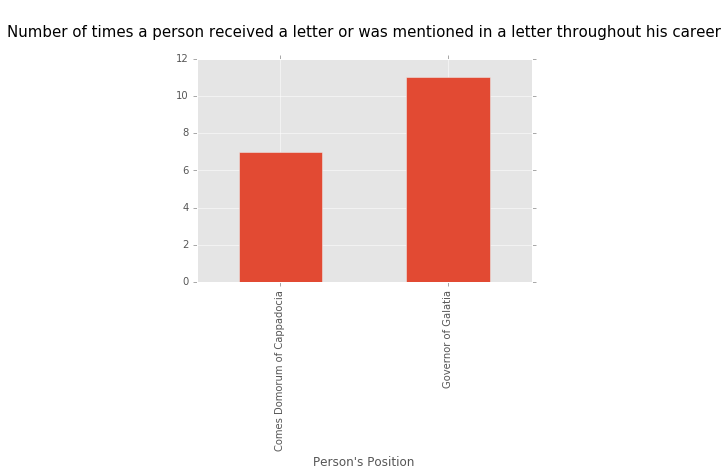

In [16]:
positions.groupby("Person's Position").count().sort_values(by = "Person's Name / PLRE ID / BLZG ID")["Person's Name / PLRE ID / BLZG ID"].plot.bar()
plt.title("\nNumber of times a person received a letter or was mentioned in a letter throughout his career\n", fontsize=15)

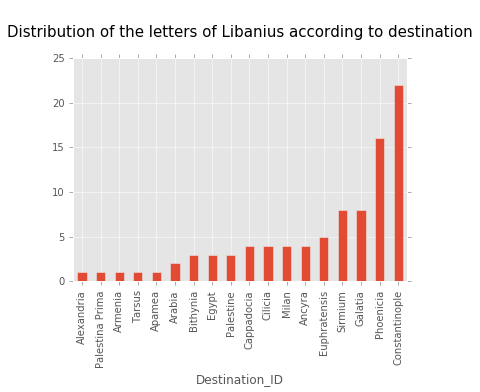

In [17]:
sql3 = """SELECT Libanius_Letters.Letter_ID, Libanius_Letters.Destination_ID
FROM Libanius_Letters
ORDER BY Libanius_Letters.Letter_ID"""

with conn.cursor() as cursor:

    cursor.execute(sql3)
    names = [ x[0] for x in cursor.description]
    result = cursor.fetchall()

df = pd.DataFrame(result, columns = names)

df = df.dropna(subset=['Destination_ID'])

df.groupby('Destination_ID').count().sort_values(by = 'Letter_ID')['Letter_ID'].plot.bar()
plt.title("\nDistribution of the letters of Libanius according to destination\n", fontsize=15)

In [18]:
import folium

sql = """
SELECT Libanius_Letters.Letter_ID, Libanius_Destinations.Destination_ID, Libanius_Destinations.Destination_Type, Libanius_Destinations.Latitude, 
Libanius_Destinations.Longitude
FROM Libanius_Letters, Libanius_Destinations
WHERE Libanius_Letters.Destination_ID = Libanius_Destinations.Destination_ID
ORDER BY Libanius_Letters.Letter_ID"""

# this is a pretty efficient code block for going from cursor to dataframe
with conn.cursor() as cursor:

    cursor.execute(sql)
    names = [ x[0] for x in cursor.description]
    result = cursor.fetchall()

destinations = pd.DataFrame(result, columns = names)

destinations['Total'] = destinations.groupby(['Destination_ID'])['Destination_ID'].transform('count')

libanius_letters = folium.Map(location=[35, 22], zoom_start=4,tiles='http://{s}.tile.openstreetmap.se/hydda/base/{z}/{x}/{y}.png',
                   attr='Tiles courtesy of <a href="http://openstreetmap.se/" target="_blank">OpenStreetMap Sweden</a> &mdash; Map data &copy; <a href="http://www.openstreetmap.org/copyright">OpenStreetMap</a>')

galatia_geo = '.\Maps\map_Galatia.geojson'
egypt_geo = '.\Maps\map_Egypt2.geojson'
cappadocia_geo = '.\Maps\map_Cappadocia.geojson'
bithynia_geo = '.\Maps\map_Bithynia3.geojson'
armenia_geo = '.\Maps\map_Armenia.geojson'
cilicia_geo = '.\Maps\map_Cilicia.geojson'
euphratensis_geo = '.\Maps\map_Euphratensis.geojson'
palestine_geo = '.\Maps\map_Palestine.geojson'
phoenicia_geo = '.\Maps\map_Phoenicia2.geojson'
arabia_geo = '.\Maps\map_Arabia.geojson'

libanius_letters.choropleth(geo_path=galatia_geo, fill_color="#FF0000", fill_opacity=0.8)
libanius_letters.choropleth(geo_path=egypt_geo, fill_color="#CC00FF", fill_opacity=0.8)
libanius_letters.choropleth(geo_path=cappadocia_geo, fill_color="#CC00FF", fill_opacity=0.8)
libanius_letters.choropleth(geo_path=bithynia_geo, fill_color="#CC00FF", fill_opacity=0.8)
libanius_letters.choropleth(geo_path=armenia_geo, fill_color="#0000FF", fill_opacity=0.8)
libanius_letters.choropleth(geo_path=cilicia_geo, fill_color="#CC00FF", fill_opacity=0.8)
libanius_letters.choropleth(geo_path=euphratensis_geo, fill_color="#FF0000", fill_opacity=0.8)
libanius_letters.choropleth(geo_path=palestine_geo, fill_color="#CC00FF", fill_opacity=0.8)
libanius_letters.choropleth(geo_path=phoenicia_geo, fill_color="#FF0000", fill_opacity=0.8)
libanius_letters.choropleth(geo_path=arabia_geo, fill_color="#CC00FF", fill_opacity=0.8)

for index, row in destinations.iterrows():
    if row["Destination_Type"] == "City":
        if row["Total"] == 1:
            folium.Marker([row["Latitude"], row["Longitude"]], popup=row["Destination_ID"]+ ", 1 Letter : F" + str(row["Letter_ID"]), 
                      icon = folium.Icon(icon = 'pushpin', color ='blue')).add_to(libanius_letters)
        elif row["Total"] >= 2 and row["Total"] < 5:
            folium.Marker([row["Latitude"], row["Longitude"]], popup=row["Destination_ID"]+ ", " + str(row["Total"]) + " Letters", 
                      icon = folium.Icon(icon = 'pushpin', color ='purple')).add_to(libanius_letters)
        else:
            folium.Marker([row["Latitude"], row["Longitude"]], popup=row["Destination_ID"]+ ", " + str(row["Total"]) + " Letters", 
                      icon = folium.Icon(icon = 'pushpin', color ='red')).add_to(libanius_letters)
    if row["Destination_Type"] == "Region":        
        if row["Total"] > 0 and row["Total"] < 2:
            folium.Marker([row["Latitude"], row["Longitude"]], popup=row["Destination_ID"]+ ", 1 Letter : F" + str(row["Letter_ID"]), 
                      icon = folium.Icon(icon = 'question-sign', color ='blue')).add_to(libanius_letters)
        elif row["Total"] >= 2 and row["Total"] < 5:
            folium.Marker([row["Latitude"], row["Longitude"]], popup=row["Destination_ID"]+ ", " + str(row["Total"]) + " Letters", 
                      icon = folium.Icon(icon = 'question-sign', color ='purple')).add_to(libanius_letters)
        else:
            folium.Marker([row["Latitude"], row["Longitude"]], popup=row["Destination_ID"]+ ", " + str(row["Total"]) + " Letters", 
                      icon = folium.Icon(icon = 'question-sign', color ='red')).add_to(libanius_letters)
            
folium.Marker([36.20138, 36.161749], popup="Antioch, Home of Libanius and Origin of the Letters",icon = folium.Icon(icon = 'fullscreen', color ='green')).add_to(libanius_letters)

libanius_letters

In [19]:
sql2 = """
SELECT Libanius_Destinations.Destination_ID
FROM Libanius_Letters, Libanius_Destinations
WHERE (Libanius_Letters.Destination_ID = Libanius_Destinations.Destination_ID)
    AND (Libanius_Destinations.Destination_Type = "Region")
ORDER BY Libanius_Destinations.Destination_ID"""

# this is a pretty efficient code block for going from cursor to dataframe
with conn.cursor() as cursor:

    cursor.execute(sql2)
    names = [ x[0] for x in cursor.description]
    result = cursor.fetchall()

destinations_choropleth = pd.DataFrame(result, columns = names)

destinations_choropleth['Total'] = destinations_choropleth.groupby(['Destination_ID'])['Destination_ID'].transform('count')

destinations_choropleth.to_csv('Choropleth\destinations_choropleth.csv')

provinces_geo = 'Choropleth\map_provinces.geojson'
provinces_letters = 'Choropleth\destinations_choropleth.csv'

provinces_data = pd.read_csv(provinces_letters)

libanius_letters3 = folium.Map(location=[35, 22], zoom_start=4,tiles='http://{s}.tile.openstreetmap.se/hydda/base/{z}/{x}/{y}.png',
                   attr='Tiles courtesy of <a href="http://openstreetmap.se/" target="_blank">OpenStreetMap Sweden</a> &mdash; Map data &copy; <a href="http://www.openstreetmap.org/copyright">OpenStreetMap</a>')

libanius_letters3.choropleth(geo_path=provinces_geo,
                             data_out='data1.json',
                             data=provinces_data,
                             columns=['Destination_ID', 'Total'],
                             key_on='feature.properties.name',
                             threshold_scale=[0, 2, 4, 6, 8, 22],
                             fill_color='YlOrRd', fill_opacity=0.7, line_opacity=0.5,
                             legend_name="Number of Letters per Province")

for index, row in destinations.iterrows():
    if row["Destination_Type"] == "City":
        if row["Total"] == 1:
            folium.Marker([row["Latitude"], row["Longitude"]], popup=row["Destination_ID"]+ ", 1 Letter : F" + str(row["Letter_ID"]), 
                      icon = folium.Icon(icon = 'pushpin', color ='blue')).add_to(libanius_letters3)
        elif row["Total"] >= 2 and row["Total"] < 5:
            folium.Marker([row["Latitude"], row["Longitude"]], popup=row["Destination_ID"]+ ", " + str(row["Total"]) + " Letters", 
                      icon = folium.Icon(icon = 'pushpin', color ='purple')).add_to(libanius_letters3)
        else:
            folium.Marker([row["Latitude"], row["Longitude"]], popup=row["Destination_ID"]+ ", " + str(row["Total"]) + " Letters", 
                      icon = folium.Icon(icon = 'pushpin', color ='red')).add_to(libanius_letters3)
    if row["Destination_Type"] == "Region":        
        if row["Total"] > 0 and row["Total"] < 2:
            folium.Marker([row["Latitude"], row["Longitude"]], popup=row["Destination_ID"]+ ", 1 Letter : F" + str(row["Letter_ID"]), 
                      icon = folium.Icon(icon = 'question-sign', color ='blue')).add_to(libanius_letters3)
        elif row["Total"] >= 2 and row["Total"] < 5:
            folium.Marker([row["Latitude"], row["Longitude"]], popup=row["Destination_ID"]+ ", " + str(row["Total"]) + " Letters", 
                      icon = folium.Icon(icon = 'question-sign', color ='purple')).add_to(libanius_letters3)
        else:
            folium.Marker([row["Latitude"], row["Longitude"]], popup=row["Destination_ID"]+ ", " + str(row["Total"]) + " Letters", 
                      icon = folium.Icon(icon = 'question-sign', color ='red')).add_to(libanius_letters3)

folium.Marker([36.20138, 36.161749], popup="Antioch, Home of Libanius and Origin of the Letters",icon = folium.Icon(icon = 'fullscreen', color ='green')).add_to(libanius_letters3)


libanius_letters3

In [20]:
conn.commit()
conn.close()